### Predicting power consumption using historical data

In [34]:
# Adding packages

import sys
import os as os
import glob
import fnmatch
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


# Importing data

In [21]:
#sample data
os.getcwd()
df = pd.read_csv('./data/2008/1/1')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2008-01-01,00:00:00,1.620,0.070,241.25,6.6,0.0,0.0,18.0
1,2008-01-01,00:01:00,1.626,0.072,241.74,6.6,0.0,0.0,18.0
2,2008-01-01,00:02:00,1.622,0.072,241.52,6.6,0.0,0.0,18.0
3,2008-01-01,00:03:00,1.612,0.070,240.82,6.6,0.0,0.0,18.0
4,2008-01-01,00:04:00,1.612,0.070,240.80,6.6,0.0,0.0,18.0


In [60]:
#reading all files from year folders and concatenating into one df
path = './data/'
configfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    for f in fnmatch.filter(files, '*')]

li = []

for filename in configfiles:
    df = pd.read_csv(filename, header=0, parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=False)
frame.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2008-01-01 00:00:00,1.620,0.070,241.25,6.6,0.0,0.0,18.0
2008-01-01 00:01:00,1.626,0.072,241.74,6.6,0.0,0.0,18.0
2008-01-01 00:02:00,1.622,0.072,241.52,6.6,0.0,0.0,18.0
2008-01-01 00:03:00,1.612,0.070,240.82,6.6,0.0,0.0,18.0
2008-01-01 00:04:00,1.612,0.070,240.80,6.6,0.0,0.0,18.0


In [61]:
#sorting by date
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1529103 entries, 2008-01-01 00:00:00 to 2010-09-09 23:59:00
Data columns (total 7 columns):
Global_active_power      1507059 non-null float64
Global_reactive_power    1507059 non-null float64
Voltage                  1507059 non-null float64
Global_intensity         1507059 non-null float64
Sub_metering_1           1507059 non-null float64
Sub_metering_2           1507059 non-null float64
Sub_metering_3           1507059 non-null float64
dtypes: float64(7)
memory usage: 93.3 MB


#### 1) The data included 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same. 

#### 2) I merged two columns 'Date' and 'Time' to 'dt'. 

#### 3) I also converted in the above, the data to time-series type, by taking index to be the time. 

In [62]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1529103 entries, 2008-01-01 00:00:00 to 2010-09-09 23:59:00
Data columns (total 7 columns):
Global_active_power      1507059 non-null float64
Global_reactive_power    1507059 non-null float64
Voltage                  1507059 non-null float64
Global_intensity         1507059 non-null float64
Sub_metering_1           1507059 non-null float64
Sub_metering_2           1507059 non-null float64
Sub_metering_3           1507059 non-null float64
dtypes: float64(7)
memory usage: 93.3 MB


In [63]:
frame.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [64]:
frame.shape

(1529103, 7)

In [65]:
frame.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.507059e+06,1.507059e+06,1.507059e+06,1.507059e+06,1.507059e+06,1.507059e+06,1.507059e+06
mean,1.070974e+00,1.257804e-01,2.413339e+02,4.530597e+00,1.080997e+00,1.166741e+00,6.676196e+00
std,1.006783e+00,1.140179e-01,2.947698e+00,4.223206e+00,6.033656e+00,5.412778e+00,8.507126e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.200000e-01,5.000000e-02,2.395500e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.200000e-01,1.000000e-01,2.413500e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.514000e+00,1.960000e-01,2.431500e+02,6.200000e+00,0.000000e+00,1.000000e+00,1.800000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [66]:
frame.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [67]:
for j in range(1,7):
       print(frame.iloc[:, j].unique())

[0.07  0.072 0.    0.098 0.1   0.102 0.104 0.118 0.212 0.208 0.21  0.13
 0.078 0.08  0.092 0.088 0.084 0.218 0.216 0.222 0.22  0.244 0.326 0.324
 0.322 0.226 0.11  0.068 0.106 0.114 0.112 0.184 0.214 0.076 0.202 0.138
 0.086 0.096 0.18  0.254 0.32  0.236 0.082 0.09  0.094 0.17  0.238 0.242
 0.24  0.2   0.204 0.152 0.066 0.198 0.196 0.194 0.19  0.188 0.14  0.162
 0.046 0.174 0.206 0.124 0.108 0.192 0.048 0.334 0.332 0.336 0.258 0.15
 0.166 0.12  0.05  0.058 0.228 0.268 0.23  0.158 0.126 0.128 0.134 0.314
 0.328 0.316 0.224 0.054 0.148 0.186 0.178 0.156 0.264 0.16  0.248 0.46
 0.472 0.58  0.588 0.494 0.554 0.558 0.482 0.484 0.488 0.48  0.456 0.366
 0.4   0.426 0.342 0.33  0.276 0.414 0.382 0.39  0.364 0.374 0.232 0.256
 0.234 0.304 0.282 0.344 0.36  0.384 0.42  0.376 0.406 0.368 0.388 0.372
 0.37  0.34  0.064 0.418 0.404 0.294 0.308 0.29  0.298 0.06  0.074 0.116
 0.056 0.052 0.062 0.132 0.146 0.312 0.468 0.44  0.454 0.476 0.144 0.122
 0.168 0.142 0.246 0.458 0.496 0.49  0.486 0.462 0.464

#  Dealing with missing values  'nan' with a test statistic

In [68]:
## finding all columns that have nan:
droping_list_all=[]
for j in range(0,7):
    if not frame.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(frame.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [72]:
# filling nan with mean in any columns -  
#probably it could make sense to check the seasonlaity and then fill the mean but just keeping it simple for now.

for j in range(0,7):        
        frame.iloc[:,j]=frame.iloc[:,j].fillna(frame.iloc[:,j].mean())
        


In [73]:
# another sanity check to make sure that there are not more any nan
frame.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [74]:
frame.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.529103e+06,1.529103e+06,1.529103e+06,1.529103e+06,1.529103e+06,1.529103e+06,1.529103e+06
mean,1.070974e+00,1.257804e-01,2.413339e+02,4.530597e+00,1.080997e+00,1.166741e+00,6.676196e+00
std,9.994992e-01,1.131930e-01,2.926373e+00,4.192654e+00,5.990007e+00,5.373621e+00,8.445583e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.220000e-01,5.000000e-02,2.395900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.520000e-01,1.020000e-01,2.413339e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.506000e+00,1.960000e-01,2.431200e+02,6.200000e+00,0.000000e+00,1.000000e+00,1.800000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [75]:
frame['Global_active_power'].resample('M').sum()

dt
2008-01-31    65170.452974
2008-02-29    49334.284923
2008-03-31    55591.664974
2008-04-30    48209.992000
2008-05-31    45724.001949
2008-06-30    42945.042974
2008-07-31    35479.559949
2008-08-31    12344.021949
2008-09-30    42667.792000
2008-10-31    52260.849903
2008-11-30    59918.398770
2008-12-31    56909.951188
2009-01-31    62951.078974
2009-02-28    50290.632367
2009-03-31    54761.127949
2009-04-30    49277.665949
2009-05-31    45214.113898
2009-06-30    37081.550663
2009-07-31    27594.727898
2009-08-31    30030.642264
2009-09-30    42631.776923
2009-10-31    51089.790974
2009-11-30    55068.712974
2009-12-31    60907.147949
2010-01-31    62732.879103
2010-02-28    55473.847949
2010-03-31    50326.763275
2010-04-30    44379.194974
2010-05-31    48893.470974
2010-06-30    41887.565949
2010-07-31    32188.822974
2010-08-31    29842.235608
2010-09-30    41918.117363
2010-10-31    51934.024974
2010-11-30    44598.388000
Freq: M, Name: Global_active_power, dtype: float64

# Data visualization


#### * Below I resampled over day, and show the sum and mean of Global_active_power. It is seen that mean and sum of resampled data set, have similar structure.

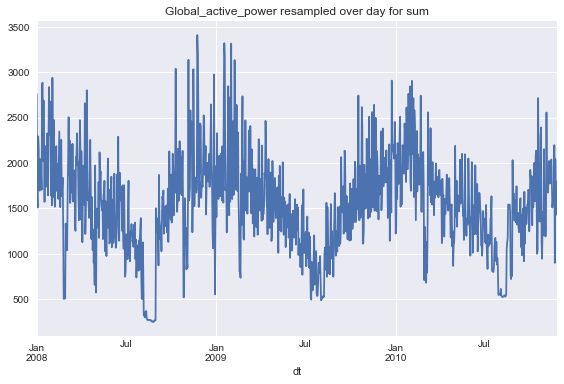

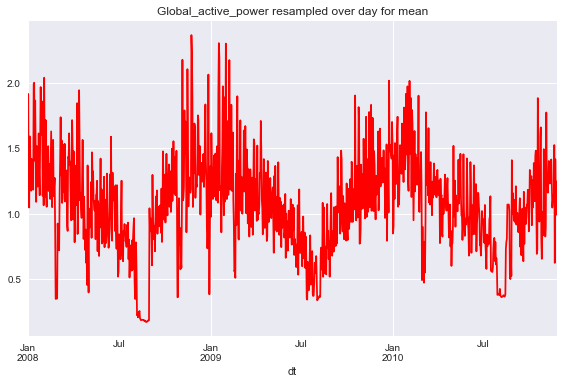

In [76]:
frame.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#frame.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

frame.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

#### Mean and std of 'Global_intensity' resampled over day 

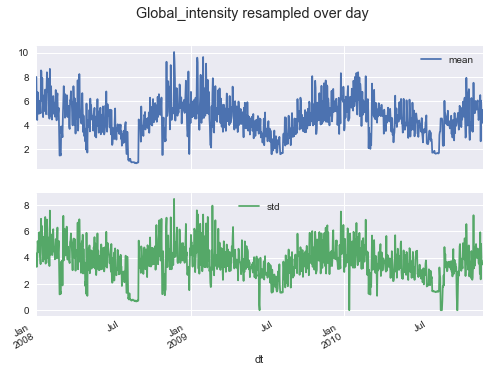

In [77]:
r = frame.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

#### mean and std of 'Global_reactive_power' resampled over day 

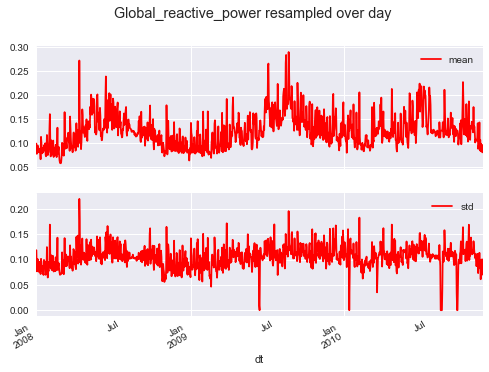

In [78]:
r2 = frame.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

### Sum of 'Global_active_power' resampled over month

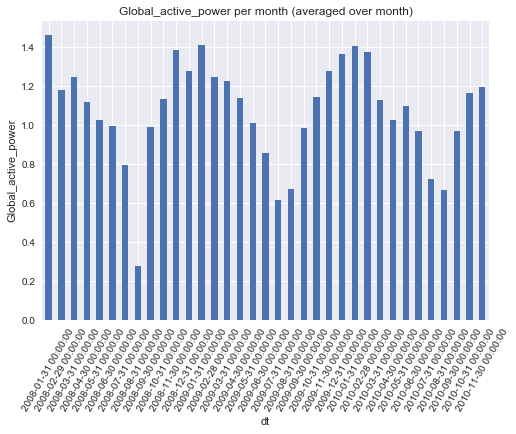

In [79]:
# Sum of 'Global_active_power' resampled over month
frame['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

#### Mean of 'Global_active_power' resampled over quarter

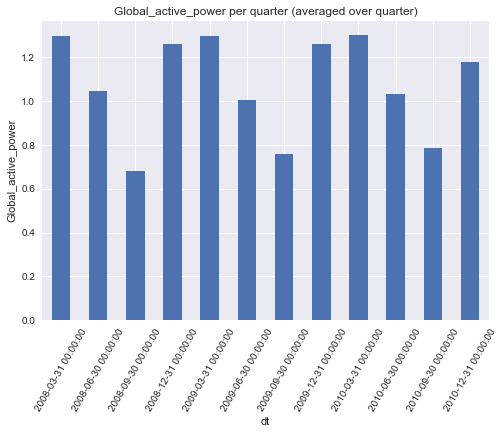

In [80]:
frame['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

#### It is easy to notice that  resampling over larger time inteval, will diminish the periodicity.

#### mean of 'Voltage' resampled over month

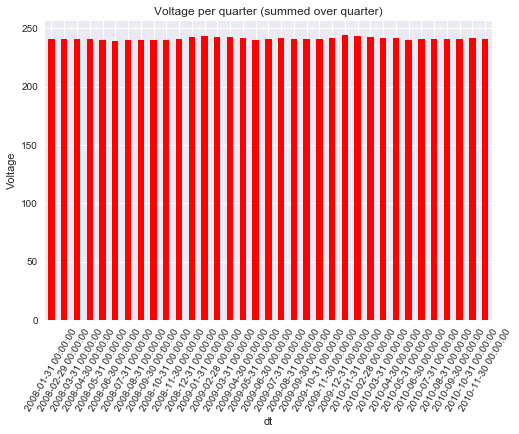

In [81]:
frame['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

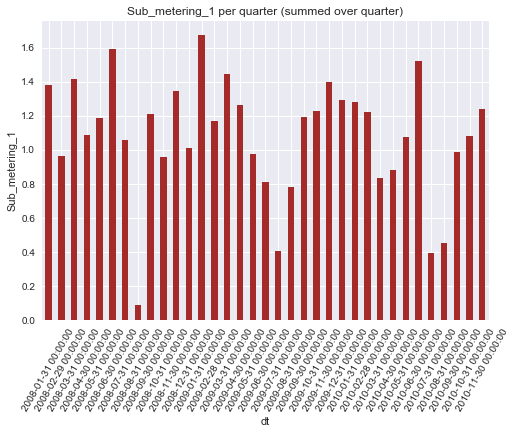

In [82]:
frame['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

#### * It can be seen from the above plots that the mean of 'Volage' over month is pretty much constant compared to other features. This is important again in feature selection.  

### Comparison of the mean of different features resampled over day. 

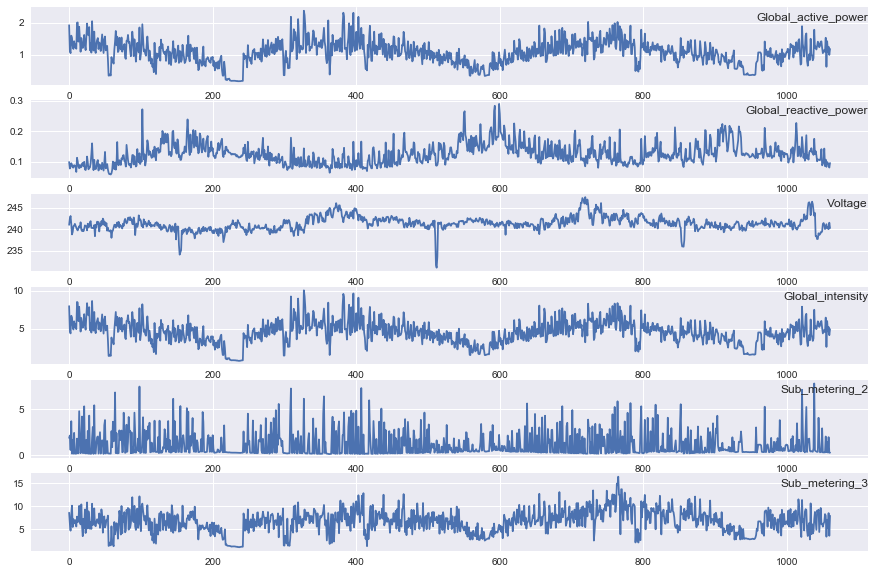

In [84]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = frame.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(frame.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

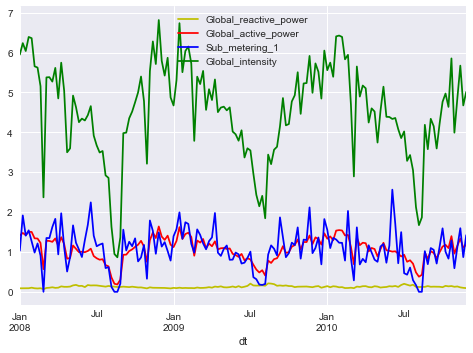

In [85]:
## resampling over week and computing mean
frame.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
frame.Global_active_power.resample('W').mean().plot(color='r', legend=True)
frame.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
frame.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

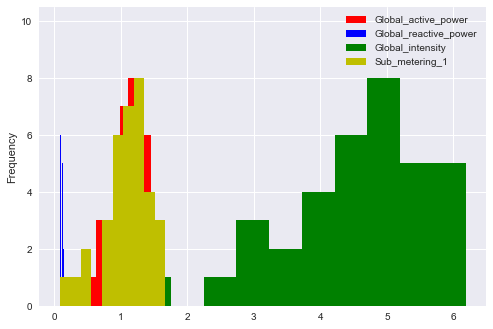

In [86]:
# Histogram of the mean of different feature resampled over month 
frame.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
frame.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
#frame.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
frame.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
frame.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

### The correlations between 'Global_intensity' and  'Global_active_power'

C:\Users\Kshitij.Srivastava\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


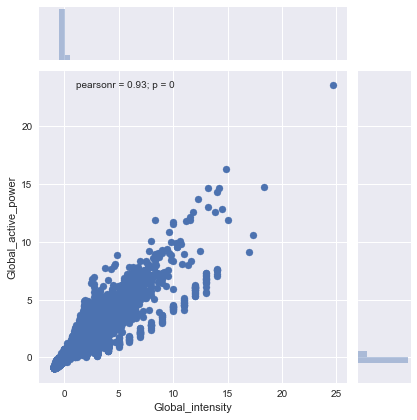

In [87]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = frame.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

C:\Users\Kshitij.Srivastava\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


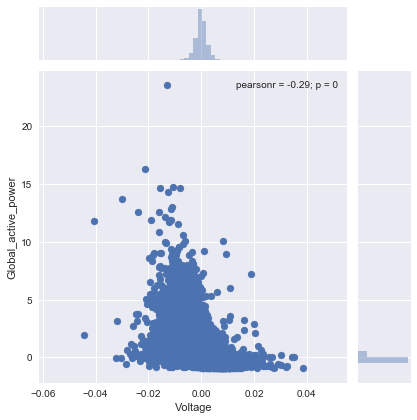

In [88]:
## The correlations between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

#### * From above two plots it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated. This is important observation for machine learning purpose. 

## Correlations among features

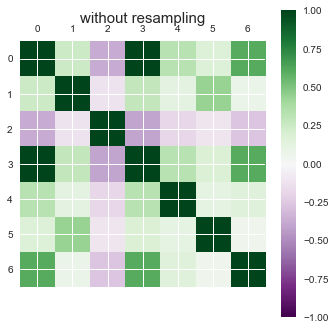

In [89]:
# Correlations among columns
plt.matshow(frame.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

# Correlations of mean of resampled features 

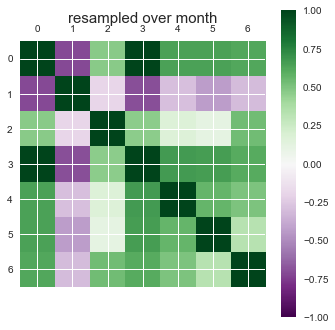

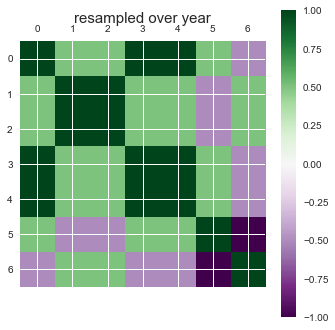

In [90]:
# Correlations of mean of features resampled over months


plt.matshow(frame.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(frame.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

#### * It is seen from above that with resampling techniques one can change the correlations among features. This is important for feature  engineering.

## Machine-Leaning: LSTM Data Preparation and feature engineering

### * We will apply recurrent nueral network (LSTM) which is best suited for time-series and sequential problems. This approach is preferable if data size is large.  

#### * Here we frame the supervised learning problem as predicting the Global_active_power at the current time (t) given the Global_active_power measurement and other features at the prior time step.

In [91]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

#### * In order to reduce the computation time, and also get a quick result to test the model.  One can resmaple the data over hour (the original data are given in minutes). This will reduce the size of data from to 25462 but keep the overall strucure of data as shown in the above.   

In [92]:
## resampling of data over hour
df_resample = frame.resample('h').mean() 
df_resample.shape

(25462, 7)

### * Scaling all features in range of [0,1]. 

In [93]:
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.228840   0.059966   0.588302   0.217838        0.0   0.000000   
2   0.232356   0.112828   0.559559   0.222382        0.0   0.010243   
3   0.365062   0.094748   0.635741   0.347322        0.0   0.000000   
4   0.405052   0.098579   0.602630   0.384505        0.0   0.010622   
5   0.358443   0.078950   0.568895   0.340268        0.0   0.000000   

   var7(t-1)   var1(t)  
1   0.830626  0.232356  
2   0.825986  0.365062  
3   0.838360  0.405052  
4   0.832947  0.358443  
5   0.826759  0.365984  


#### * Above I showed 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current  time in hour (depending on resampling). 

### Splitting the rest of data to train and validation sets

#### * First, I split the prepared dataset into train and test sets. To speed up the training of the model (for the sake of the demonstration), we will only train the model on the first year of data, then evaluate it on the subsequent data.

In [96]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (16701, 1, 7) (16701,)


# Model architecture

### 1)  LSTM with 100 neurons in the first visible layer 
### 3) dropout 20%
### 4) 1 neuron in the output layer for predicting Global_active_power. 
### 5) The input shape will be 1 time step with 7 features.

### 6) We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
### 7) The model will be fit for 20 training epochs with a batch size of 70.



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 16701 samples
Epoch 1/20
 - 1s - loss: 0.0152 - val_loss: 0.0108
Epoch 2/20
 - 0s - loss: 0.0109 - val_loss: 0.0093
Epoch 3/20
 - 0s - loss: 0.0100 - val_loss: 0.0087
Epoch 4/20
 - 0s - loss: 0.0096 - val_loss: 0.0086
Epoch 5/20
 - 1s - loss: 0.0095 - val_loss: 0.0086
Epoch 6/20
 - 1s - loss: 0.0094 - val_loss: 0.0086
Epoch 7/20
 - 1s - loss: 0.0094 - val_loss: 0.0087
Epoch 8/20
 - 0s - loss: 0.0093 - val_loss: 0.0086
Epoch 9/20
 - 0s - loss: 0.0093 - val_loss: 0.0085
Epoch 10/20
 - 0s - loss: 0.0093 - val_loss: 0.0086
Epoch 11/20
 - 0s - loss: 0.0092 - val_loss: 0.0086
Epoch 12/20
 - 0s - loss: 0.0093 - val_loss: 0.0085
Epoch 13/20
 - 0s - loss: 0.0092 - val_loss: 0.0085
Epoch 14/20
 - 1s - loss: 0.0092 - val_loss: 0.00

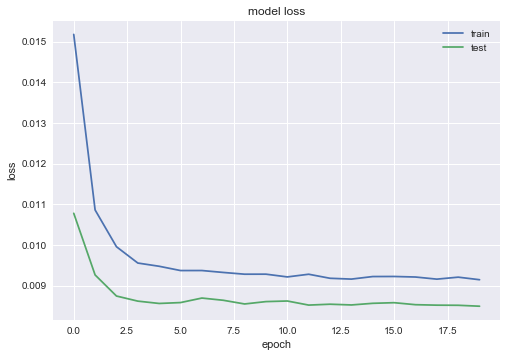

Test RMSE: 0.593


In [97]:

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


#### To improve the model, we can adjust epochs and batch_size.


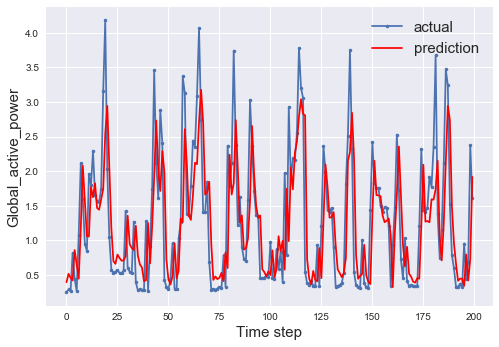

In [98]:
## time steps, every step is one hour (we can easily convert the time step to the actual time index)
## Let's compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Final thoughts about the model

#### * Here I have used the LSTM which is now the state-of-the-art for sequencial or time-series problems. 

#### * In order to reduce the computation time, and get some results quickly, I took the first year of data (resampled over hour) to train the model and the rest of data to test the model.  The above codes work for any time interval (just one has to change one line to change the interval). 

#### * I put together a very simple LSTM neural-network to show that one can obtain reasonable predictions. However numbers of rows is too high and as a result the computation is very time-consuming (even for the simple model in the above it took few mins. An alternate way to do this would be to write the last part of code using Spark (MLlib) running on GPU.  

#### * Moreover, the neural-network architecture that I have designed is a toy model. It can be easily improved by dropout and adding CNN layers. CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).   

#### * I think it'll be an interesting exercise to deploy this model as a REST API. We can use the Flask web framework to create an endpoint and then JSON-ify the predictions, and return the results to the client.